# Exercises for Introduction to Quantum Computing

Name: Pugazharasu Anancia Devaneyan (s6puanan) <br />
Matriculation number: 3300280

In [35]:
import numpy as np
import qiskit 
import qiskit.quantum_info as qi
import qiskit.quantum_info as quantu_info
from qiskit import IBMQ, Aer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, transpile, execute
import math
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import QFT
from qiskit.providers.aer import Aer

## 1. Addition by Quantum Fourier Transform

In this exercise sheet we would like to implement a Quantum adder i.e. a Quantum circuit that could add two numbers stored in two quantum registers upto modulo $2^{n}$ where $n$ is the number of Qubits in the Quantum register

a) The action of the $R_{j}(y)$ on a qubit $| \psi \rangle = |0\rangle+e^{2 \pi i x 2^{-j}}|1\rangle$ is given by,
$$R_{j}(y) | \psi \rangle = |0\rangle+e^{2 \pi i\left(x 2^{-j}+y 2^{-j}\right)}|1\rangle $$
This resembles the action of a phase gate and is indeed, a phase rotation gate of the form
$$R_{j}(y) = \begin{pmatrix}
1 & 0 \\
0 & e^{2 \pi iy.2^{-j}}
\end{pmatrix}$$
Such a matrix can be implemented via the gate

b) We are to evaluate
$$
A(y)=\mathrm{qFT}^{\dagger}\left(R_n(y) R_{n-1}(y) \ldots R_1(y)\right) \mathrm{qFT}
$$
acting on an $n$-qubit register $|x\rangle=\left|x_1 x_2 \ldots x_n\right\rangle$.
$$
A(y) |x\rangle = \mathrm{qFT}^{\dagger}\left(R_n(y) R_{n-1}(y) \ldots R_1(y)\right) \mathrm{qFT} |x\rangle
$$
Evaluating the action of the $qFT$ on $|x\rangle$, we get,
$$
A(y) |x\rangle = \frac{1}{2^{\frac{n}{2}}} \mathrm{qFT}^{\dagger}\left(R_n(y) R_{n-1}(y) \ldots R_1(y)\right) \sum^{2^{n}-1}_{k=0} e^{\frac{2 \pi i kx}{2^{n}}} | k \rangle
$$
the action of the rotation gates, adds a phase to the exponential,
$$
A(y) |x\rangle = \frac{1}{2^{\frac{n}{2}}} \mathrm{qFT}^{\dagger} \sum^{2^{n}-1}_{k=0} e^{\frac{2 \pi i k(x+y)}{2^{n}}} | k \rangle
$$
the inverse-qFT 
$$
A(y) |x\rangle = \frac{1}{2^{\frac{n}{2}}} \mathrm{qFT}^{\dagger} \sum^{2^{n}-1}_{k=0} e^{\frac{2 \pi i k(x+y)}{2^{n}}} | k \rangle
$$
From the theory of discrete-Fourier transforms, we have the identity,
$$
\delta_{b,c} = \frac{1}{N} \sum^{N}_{j=1} e^{\frac{2 \pi i j.(b-c)}{N}}
$$
where,
$$
\delta_{b,c} = 
\begin{cases}
1 & \text{if, } b = c \\
0 & \text{if, } b \neq c \\
\end{cases}
$$
Applying this to the previous equation,
$$
A(y) |x\rangle = \sum^{2^{n}-1}_{m=0} \delta_{x+y,m} |m \rangle
$$
thus we have,
$$
\begin{align}
A(y) |x\rangle = |x+y \  (\text{mod } 2^{n})\rangle
\end{align}
$$

c) For the case of $x + y \geq 2^{n}$, we have
$$x+y \neq m$$
as $m$ lies between $0$ and $2^{n}-1$, thus we would have
$$A(y) | x \rangle = 0$$
$\forall x + y \geq 2^{n}$

d) Let's now implement the circuit for the case of 3-Qubits,

In [36]:
# Defining the swap function for the action of SWAP gates over all Qubits
def swap_registers(circuit, n):
    """Swaps all the Qubits in the circuit by means of applying appropriate SWAP gates

    Args:
        circuit (QuantumCircuit): 
        n (int): Number  of Qubits

    Returns:
        QuantumCircuit : Returns the swapped circuit
    """
    for qubit in range(n//2):
        circuit.swap(qubit, n-qubit-1)
    return circuit


def A(y,qubits):
    """ Performs an addition of x (stored in the qubits) and y provided x + y < 2^{n} (n = number of Qubits)

    Args:
        y (int): the integer to be added  to x
        qubits (int): number of qubits

    Returns:
        QuantumCircuit : Returns the Quantum adder circuit
    """
    # Create and set up circuit
    qFT_adder = QuantumCircuit(qubits)
    qFT_adder = qFT_adder.compose(QFT(qubits, inverse=False), np.arange(0,qubits,1))
    swap_registers(qFT_adder,3)
    for k in range(qubits):
        param = (2*np.pi*y)/(2**(k+1))
        qFT_adder.p(param,k)
        qFT_adder.barrier()
    swap_registers(qFT_adder,3)
    qFT_adder = qFT_adder.compose(QFT(qubits, inverse=True), np.arange(0,qubits,1))
    return qFT_adder

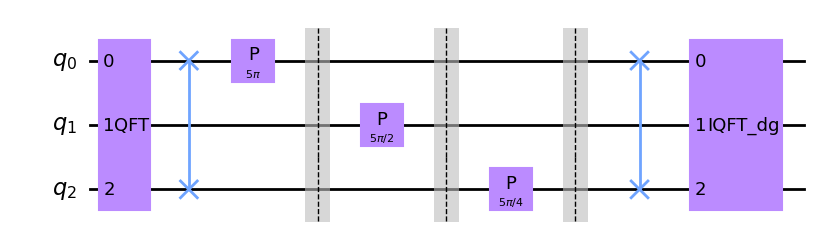

In [37]:
A(5,3).draw('mpl')

In [38]:
qFT_adder = A(5,3)

Now let's check if the circuit gives the outputs we expect

In [39]:
state_2 = qi.Statevector.from_label('000') # initialising the state as |101>
state_2 = state_2.evolve(qFT_adder)
(state_2.draw(output='latex'))

<IPython.core.display.Latex object>

In [40]:
state_2 = qi.Statevector.from_label('101') # initialising the state as |101>
state_2 = state_2.evolve(qFT_adder)
(state_2.draw(output='latex'))

<IPython.core.display.Latex object>

We see that indeed we get the expected results. We can thus conclude that we have sucessfully implemented the Quantum adder circuit for the case of 3 Qubits.

e) We are to compute,
$$c A_{y, x}|y\rangle|x\rangle=\mathrm{qFT}_x^{\dagger}\left(\prod_{\ell_n=1}^n c R_{y_{\ell_n}} x_n\left(2^{n-\ell_n}\right) \prod_{\ell_{n-1}=2}^n c R_{y_{\ell_{n-1}} x_{n-1}}\left(2^{n-\ell_{n-1}}\right) \ldots \prod_{\ell_1=n}^n c R_{y_{\ell_1} x_1}\left(2^{n-\ell_1}\right)\right) \mathrm{qFT}_x|y\rangle|x\rangle$$
Let us begin by computing the action of the qFT.
$$qFT_{x} |y\rangle|x\rangle = $$
